In [140]:
# # Cell 1: Setup & Imports

import os
import time
import requests
from datetime import datetime, timedelta
from typing import List, Dict, Optional, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, MonthLocator, YearLocator
from matplotlib.ticker import MaxNLocator

import torch
from transformers import BertForSequenceClassification, AutoTokenizer, pipeline
from tqdm.notebook import tqdm
import yfinance as yf
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Optional: load .env for API keys
try:
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass

print("✅ All imports loaded successfully")

✅ All imports loaded successfully


In [141]:
# # Cell 2: Configuration

class Config:
    """Central configuration for the analysis"""
    
    # ==================== API KEYS ====================
    FINNHUB_API_KEY = os.getenv("FINNHUB_API_KEY", "d4499khr01qge0d154q0d4499khr01qge0d154qg")  # Get free key at https://finnhub.io
    
    # ==================== TICKERS ====================
    TICKERS = ['AAPL', 'MSFT', 'GOOGL']  # Stocks to analyze
    
    # ==================== DATA COLLECTION ====================
    NEWS_DAYS_BACK = 90  # How many days of news to fetch (max 365 for free tier)
    PRICE_HISTORY_PERIOD = "2y"  # Price history: '1y', '2y', '5y', '10y', 'max'
    
    # ==================== SENTIMENT MODEL ====================
    SENTIMENT_MODEL = "ProsusAI/finbert"  # Financial sentiment model
    SENTIMENT_LABELS = {0: "positive", 1: "negative", 2: "neutral"}
    
    # ==================== ANALYSIS PARAMETERS ====================
    ROLLING_WINDOW_DAYS = 28  # Short-term MA window
    LONG_MA_DAYS = 120  # Long-term MA window
    MIN_SENTIMENT_DAYS = 30  # Minimum days needed for analysis
    
    # ==================== PREDICTION PARAMETERS ====================
    PREDICTION_HORIZON = 3  # Days ahead to predict
    TRAIN_TEST_SPLIT = 0.8  # 80% train, 20% test
    
    # ==================== TRADING STRATEGY ====================
    SENTIMENT_BUY_THRESHOLD = 0.2  # Buy when sentiment > this
    SENTIMENT_SELL_THRESHOLD = -0.2  # Sell when sentiment < this
    
    # ==================== VISUALIZATION ====================
    FIGURE_WIDTH = 14
    FIGURE_HEIGHT = 7
    GRID_ALPHA = 0.3
    LINE_WIDTH_THIN = 1.5
    LINE_WIDTH_MEDIUM = 2.0
    LINE_WIDTH_THICK = 2.5
    
    # Color scheme
    COLOR_PRICE = '#000000'  # Black
    COLOR_MA_SHORT = '#1f77b4'  # Blue
    COLOR_MA_LONG = '#ff7f0e'  # Orange
    COLOR_SENTIMENT = '#2ca02c'  # Green
    COLOR_NEUTRAL = '#7f7f7f'  # Gray
    COLOR_POSITIVE = '#00ff00'  # Bright green
    COLOR_NEGATIVE = '#ff0000'  # Red
    
    # ==================== API RATE LIMITS ====================
    FINNHUB_CALLS_PER_MINUTE = 60  # Free tier limit
    FINNHUB_RETRY_ATTEMPTS = 3
    FINNHUB_RETRY_DELAY = 5

# Apply matplotlib defaults based on config
plt.rcParams["figure.figsize"] = (Config.FIGURE_WIDTH, Config.FIGURE_HEIGHT)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = Config.GRID_ALPHA
plt.rcParams["font.size"] = 10
plt.rcParams["lines.linewidth"] = Config.LINE_WIDTH_MEDIUM

print("✅ Configuration loaded")
print(f"   Tickers: {', '.join(Config.TICKERS)}")
print(f"   News lookback: {Config.NEWS_DAYS_BACK} days")
print(f"   Price history: {Config.PRICE_HISTORY_PERIOD}")
print(f"   Rolling window: {Config.ROLLING_WINDOW_DAYS} days")

✅ Configuration loaded
   Tickers: AAPL, MSFT, GOOGL
   News lookback: 90 days
   Price history: 2y
   Rolling window: 28 days


In [ ]:
# # Cell 3: Finnhub News Fetching

def fetch_finnhub_news(ticker: str, 
                       days_back: int = Config.NEWS_DAYS_BACK,
                       api_key: str = Config.FINNHUB_API_KEY) -> pd.DataFrame:
    """
    Fetch company news from Finnhub API.
    
    Args:
        ticker: Stock ticker symbol
        days_back: Number of days to look back
        api_key: Finnhub API key
        
    Returns:
        DataFrame with columns: ticker, datetime, title, summary, source, url
    """
    if not api_key:
        raise ValueError("❌ FINNHUB_API_KEY not set! Get one free at https://finnhub.io")
    
    # Calculate date range
    end_date = datetime.now()
    start_date = end_date - timedelta(days=days_back)
    
    # Format dates for API (YYYY-MM-DD)
    from_date = start_date.strftime('%Y-%m-%d')
    to_date = end_date.strftime('%Y-%m-%d')
    
    print(f"   Fetching {ticker} news from {from_date} to {to_date}...")
    
    # Finnhub API endpoint
    url = "https://finnhub.io/api/v1/company-news"
    params = {
        "symbol": ticker,
        "from": from_date,
        "to": to_date,
        "token": api_key
    }
    
    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        data = response.json()
        
        if not data:
            print(f"   ⚠️  No news found for {ticker}")
            return pd.DataFrame()
        
        # Parse response
        news_items = []
        for item in data:
            news_items.append({
                'ticker': ticker,
                'datetime': pd.to_datetime(item['datetime'], unit='s'),
                'title': item.get('headline', ''),
                'summary': item.get('summary', ''),
                'source': item.get('source', ''),
                'url': item.get('url', '')
            })
        
        df = pd.DataFrame(news_items)
        
        if df.empty:
            print(f"   ⚠️  No valid news for {ticker}")
            return df
        
        # Remove duplicates and sort
        df = df.drop_duplicates(subset=['datetime', 'title'])
        df = df.sort_values('datetime')
        
        print(f"   ✅ Found {len(df)} news articles for {ticker}")
        return df
        
    except requests.exceptions.RequestException as e:
        print(f"   ❌ API error for {ticker}: {e}")
        return pd.DataFrame()


def fetch_all_news(tickers: List[str], 
                   days_back: int = Config.NEWS_DAYS_BACK) -> pd.DataFrame:
    """
    Fetch news for multiple tickers from Finnhub.
    
    Args:
        tickers: List of ticker symbols
        days_back: Days to look back
        
    Returns:
        Combined DataFrame with all news
    """
    print(f"🔍 Fetching news from Finnhub for {len(tickers)} tickers...")
    print(f"   Lookback period: {days_back} days")
    
    all_news = []
    calls = 0
    
    for ticker in tickers:
        # Rate limiting
        if calls > 0 and calls % Config.FINNHUB_CALLS_PER_MINUTE == 0:
            print(f"   ⏸️  Rate limit pause (60s)...")
            time.sleep(60)
        
        # Fetch with retry
        for attempt in range(Config.FINNHUB_RETRY_ATTEMPTS):
            try:
                df = fetch_finnhub_news(ticker, days_back)
                if not df.empty:
                    all_news.append(df)
                break
            except Exception as e:
                if attempt < Config.FINNHUB_RETRY_ATTEMPTS - 1:
                    print(f"   🔄 Retry {attempt + 1}/{Config.FINNHUB_RETRY_ATTEMPTS}...")
                    time.sleep(Config.FINNHUB_RETRY_DELAY)
                else:
                    print(f"   ❌ Failed after {Config.FINNHUB_RETRY_ATTEMPTS} attempts: {e}")
        
        calls += 1
        time.sleep(0.5)  # Small delay between tickers
    
    if not all_news:
        print("❌ No news data retrieved!")
        return pd.DataFrame()
    
    # Combine all news
    df_combined = pd.concat(all_news, ignore_index=True)
    df_combined = df_combined.sort_values('datetime')
    
    print(f"✅ Total news articles: {len(df_combined)}")
    print(f"   Date range: {df_combined['datetime'].min()} to {df_combined['datetime'].max()}")
    
    return df_combined


# ['ticker', 'datetime', 'title', 'summary', 'source', 'url']

In [143]:
def fetch_daily_prices(ticker: str, period: str = Config.PRICE_HISTORY_PERIOD) -> pd.DataFrame:
    """
    Fetch daily OHLC data from Yahoo Finance.
    
    Args:
        ticker: Stock ticker symbol
        period: Data period ('1y', '2y', '5y', '10y', 'max')
        
    Returns:
        DataFrame with columns: Date, date, Open, High, Low, Close, Adj Close, Volume
    """
    stock = yf.Ticker(ticker)
    df = stock.history(period=period, auto_adjust=False)
    
    if df.empty:
        raise ValueError(f"❌ No data retrieved for {ticker} from yfinance")
    
    df = df.reset_index()
    df = df.rename(columns={"Date": "Date"})
    df["date"] = pd.to_datetime(df["Date"]).dt.date
    
    return df[["Date", "date", "Open", "High", "Low", "Close", "Adj Close", "Volume"]]



In [ ]:
# # Cell 5: Sentiment Analysis

# %%
def load_sentiment_model():
    """Load FinBERT model for financial sentiment analysis"""
    print("📦 Loading FinBERT sentiment model...")
    
    model = BertForSequenceClassification.from_pretrained(
        Config.SENTIMENT_MODEL,
        num_labels=3,
        id2label=Config.SENTIMENT_LABELS,
        label2id={v: k for k, v in Config.SENTIMENT_LABELS.items()},
    )
    model.eval()
    
    tokenizer = AutoTokenizer.from_pretrained(Config.SENTIMENT_MODEL)
    
    device = 0 if torch.cuda.is_available() else -1
    sentiment_pipeline = pipeline(
        "text-classification", 
        model=model, 
        tokenizer=tokenizer, 
        device=device,
        top_k=None, 
        padding=True, 
        truncation=True, 
        max_length=256
    )
    
    print(f"✅ Model loaded (device: {'GPU' if device == 0 else 'CPU'})")
    return sentiment_pipeline


def analyze_sentiment(df_news: pd.DataFrame, sentiment_pipeline) -> pd.DataFrame:
    """
    Apply sentiment analysis to news titles and summaries.
    
    Args:
        df_news: DataFrame with columns: ticker, datetime, title, summary
        sentiment_pipeline: Hugging Face sentiment pipeline
        
    Returns:
        DataFrame with columns: ticker, datetime, positive, neutral, negative
    """
    if df_news.empty:
        print("⚠️  No news data to analyze")
        return pd.DataFrame()
    
    results = {
        'ticker': [],
        'datetime': [],
        'positive': [],
        'neutral': [],
        'negative': []
    }
    
    print(f"🧠 Analyzing sentiment for {len(df_news)} news items...")
    
    for ticker in df_news['ticker'].unique():
        ticker_df = df_news[df_news['ticker'] == ticker]
        
        for idx in tqdm(range(len(ticker_df)), desc=f"{ticker} sentiment"):
            row = ticker_df.iloc[idx]
            
            # Combine title and summary for richer sentiment
            text = row['title']
            if pd.notna(row.get('summary')) and row['summary']:
                text += " " + row['summary'][:200]  # Limit summary length
            
            dt = row['datetime']
            
            # Get sentiment scores
            with torch.no_grad():
                outputs = sentiment_pipeline([text])[0]
            
            scores = {'positive': 0.0, 'neutral': 0.0, 'negative': 0.0}
            for item in outputs:
                scores[item['label']] = item['score']
            
            results['ticker'].append(ticker)
            results['datetime'].append(dt)
            results['positive'].append(scores['positive'])
            results['neutral'].append(scores['neutral'])
            results['negative'].append(scores['negative'])
    
    df_sentiment = pd.DataFrame(results)
    df_sentiment['datetime'] = pd.to_datetime(df_sentiment['datetime'])
    df_sentiment.set_index('datetime', inplace=True)
    df_sentiment.sort_index(inplace=True)
    
    print(f"✅ Sentiment analysis complete")
    return df_sentiment

# Columns: - ticker - positive - neutral - negative

In [ ]:
# # Cell 6: Feature Engineering

# %%
def aggregate_daily_sentiment(df_sentiment: pd.DataFrame, 
                              window: int = Config.ROLLING_WINDOW_DAYS) -> pd.DataFrame:
    """
    Aggregate intraday sentiment to daily scores with rolling averages.
    """
    df = df_sentiment.reset_index()
    
    def calc_score(row):
        pos, neg = row['positive'], row['negative']
        denom = pos + neg
        return 0.0 if denom == 0 else (pos - neg) / denom
    
    df['score'] = df.apply(calc_score, axis=1)
    
    # Daily median score
    daily_median = (
        df.groupby(['ticker', pd.Grouper(key='datetime', freq='D')])['score']
          .median()
          .reset_index()
          .rename(columns={'datetime': 'date'})
    )
    daily_median['date'] = daily_median['date'].dt.date
    
    # Daily counts
    daily_count = (
        df.groupby(['ticker', pd.Grouper(key='datetime', freq='D')])
          .size()
          .reset_index(name='entry_count')
          .rename(columns={'datetime': 'date'})
    )
    daily_count['date'] = daily_count['date'].dt.date
    
    df_daily = (
        daily_median.merge(daily_count, on=['ticker', 'date'], how='outer')
                    .sort_values(['ticker', 'date'])
    )
    
    # Rolling averages based on config
    df_daily['score_ma'] = (
        df_daily.groupby('ticker')['score']
                .transform(lambda x: x.rolling(window, min_periods=1).mean())
    )
    df_daily['entry_count_ma'] = (
        df_daily.groupby('ticker')['entry_count']
                .transform(lambda x: x.rolling(window, min_periods=1).mean())
    )
    
    df_daily.set_index(['ticker', 'date'], inplace=True)
    df_daily.fillna(0, inplace=True)
    
    return df_daily


def merge_sentiment_prices(df_daily: pd.DataFrame) -> pd.DataFrame:
    """
    Merge daily sentiment with price data and create full date range with forward-fill.
    """
    tickers = df_daily.index.get_level_values(0).unique()
    results = []
    
    print(f"📈 Fetching price data from Yahoo Finance for {len(tickers)} tickers...")
    
    for ticker in tickers:
        try:
            prices = fetch_daily_prices(ticker, Config.PRICE_HISTORY_PERIOD)
        except Exception as e:
            print(f"   ❌ Failed to fetch {ticker}: {e}")
            continue
        
        # Get sentiment data
        sentiment = df_daily.loc[ticker].reset_index()
        
        # Create full date range from price data
        prices_sorted = prices.sort_values('date')
        full_date_range = pd.DataFrame({
            'date': pd.date_range(
                start=prices_sorted['date'].min(),
                end=prices_sorted['date'].max(),
                freq='D'
            ).date
        })
        
        # Merge prices with full date range
        merged = full_date_range.merge(prices[['date', 'Close']], on='date', how='left')
        
        # Forward-fill price data for weekends/holidays
        merged['Close'] = merged['Close'].fillna(method='ffill')
        
        # Merge with sentiment (left join to keep all price dates)
        merged = merged.merge(sentiment, on='date', how='left')
        
        # Forward-fill sentiment scores
        for col in ['score', 'score_ma', 'entry_count', 'entry_count_ma']:
            if col in merged.columns:
                merged[col] = merged[col].fillna(method='ffill').fillna(0)
        
        # Add price features based on config windows
        merged['Close_MA_Short'] = merged['Close'].rolling(Config.ROLLING_WINDOW_DAYS, min_periods=1).mean()
        merged['Close_MA_Long'] = merged['Close'].rolling(Config.LONG_MA_DAYS, min_periods=1).mean()
        merged['Detrended'] = merged['Close'] - merged['Close_MA_Long']
        
        # Price change features
        merged['Price_Change'] = merged['Close'].pct_change()
        merged['Price_Change_MA'] = merged['Price_Change'].rolling(Config.ROLLING_WINDOW_DAYS).mean()
        
        merged['ticker'] = ticker
        merged = merged.dropna(subset=['Close'])
        results.append(merged)
        
        print(f"   ✅ {ticker}: {len(merged)} days merged")
    
    if not results:
        raise ValueError("❌ No price data could be merged")
    
    df_combo = pd.concat(results, ignore_index=True)
    df_combo.set_index(['ticker', 'date'], inplace=True)
    
    print(f"✅ Price merge complete: {len(df_combo)} total rows")
    return df_combo





In [146]:
# # Cell 7: Correlation Analysis

# %%
def analyze_correlations(df_combo: pd.DataFrame) -> pd.DataFrame:
    """
    Analyze correlation between sentiment and price movements.
    """
    print("\n" + "="*60)
    print("📊 CORRELATION ANALYSIS")
    print("="*60)
    
    results = []
    
    for ticker in df_combo.index.get_level_values('ticker').unique():
        tdf = df_combo.xs(ticker, level='ticker').copy()
        tdf = tdf.dropna(subset=['score_ma', 'Close', 'Price_Change'])
        
        if len(tdf) < Config.MIN_SENTIMENT_DAYS:
            print(f"\n⚠️  {ticker}: Insufficient data ({len(tdf)} days)")
            continue
        
        # Calculate correlations
        corr_sentiment_price = stats.pearsonr(tdf['score_ma'], tdf['Close'])[0]
        corr_sentiment_change = stats.pearsonr(tdf['score_ma'], tdf['Price_Change'])[0]
        
        # Lagged correlations
        lagged_corrs = {}
        for lag in [1, 3, 5, 7, 14]:
            if len(tdf) > lag:
                future_change = tdf['Price_Change'].shift(-lag)
                valid_idx = ~future_change.isna()
                if valid_idx.sum() > 10:
                    lagged_corrs[f'lag_{lag}d'] = stats.pearsonr(
                        tdf.loc[valid_idx, 'score_ma'],
                        future_change[valid_idx]
                    )[0]
        
        result = {
            'ticker': ticker,
            'data_points': len(tdf),
            'sentiment_price_corr': corr_sentiment_price,
            'sentiment_change_corr': corr_sentiment_change,
            **lagged_corrs
        }
        results.append(result)
        
        print(f"\n{ticker}:")
        print(f"  Data points: {len(tdf)}")
        print(f"  Sentiment ↔ Price: {corr_sentiment_price:+.3f}")
        print(f"  Sentiment ↔ Price Change: {corr_sentiment_change:+.3f}")
        print(f"  Lagged correlations:")
        for lag_name, corr in lagged_corrs.items():
            print(f"    {lag_name}: {corr:+.3f}")
    
    df_corr = pd.DataFrame(results)
    print("\n" + "="*60)
    return df_corr    

In [147]:
# # Cell 8: Predictive Modeling

# %%
def build_prediction_features(df_combo: pd.DataFrame, horizon: int = Config.PREDICTION_HORIZON):
    """Build features for predicting price movements."""
    print(f"\n🔧 Building prediction features (horizon: {horizon} days)...")
    
    all_X = []
    all_y = []
    all_tickers = []
    all_dates = []
    
    for ticker in df_combo.index.get_level_values('ticker').unique():
        tdf = df_combo.xs(ticker, level='ticker').copy()
        tdf = tdf.reset_index()
        
        # Create target
        tdf['target'] = (tdf['Close'].shift(-horizon) - tdf['Close']) / tdf['Close']
        tdf['target_direction'] = (tdf['target'] > 0).astype(int)
        
        # Feature engineering
        features = pd.DataFrame({
            'sentiment_score': tdf['score_ma'],
            'sentiment_change': tdf['score_ma'].diff(),
            'sentiment_momentum': tdf['score_ma'].diff(5),
            'news_volume': tdf['entry_count_ma'],
            'price_ma_ratio': tdf['Close'] / tdf['Close_MA_Short'],
            'detrended': tdf['Detrended'],
            'price_change_1d': tdf['Close'].pct_change(1),
            'price_change_5d': tdf['Close'].pct_change(5),
            'price_volatility': tdf['Close'].pct_change().rolling(14).std(),
            'rsi': calculate_rsi(tdf['Close'], 14),
            'ma_crossover': (tdf['Close_MA_Short'] - tdf['Close_MA_Long']) / tdf['Close_MA_Long'],
        })
        
        valid = ~(features.isna().any(axis=1) | tdf['target_direction'].isna())
        
        if valid.sum() < 50:
            continue
        
        all_X.append(features[valid])
        all_y.append(tdf.loc[valid, 'target_direction'])
        all_tickers.extend([ticker] * valid.sum())
        all_dates.extend(tdf.loc[valid, 'date'].tolist())
    
    if not all_X:
        return None, None, None, None
    
    X = pd.concat(all_X, ignore_index=True)
    y = pd.concat(all_y, ignore_index=True)
    metadata = pd.DataFrame({'ticker': all_tickers, 'date': all_dates})
    
    print(f"✅ Features built: {X.shape[0]} samples, {X.shape[1]} features")
    return X, y, X.columns.tolist(), metadata


def calculate_rsi(prices, period=14):
    """Calculate Relative Strength Index"""
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi


def train_prediction_model(X, y, metadata):
    """Train a Random Forest classifier."""
    print("\n" + "="*60)
    print("🤖 PREDICTIVE MODELING")
    print("="*60)
    
    split_idx = int(len(X) * Config.TRAIN_TEST_SPLIT)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]
    meta_train, meta_test = metadata[:split_idx], metadata[split_idx:]
    
    print(f"\nTrain: {len(X_train)} samples")
    print(f"Test:  {len(X_test)} samples")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("\n🎯 Training Random Forest...")
    model = RandomForestClassifier(
    n_estimators=300,          # more trees = stabler estimates
    max_depth=8,              # slightly shallower than 10 → less overfit
    min_samples_split=30,     # need more samples to justify splits
    min_samples_leaf=10,      # prevent tiny leaves memorizing noise
    max_features='sqrt',      # ~sqrt(11) → 3-4 features per split → decorrelates trees
    random_state=1234,
    n_jobs=-1
    )



    model.fit(X_train_scaled, y_train)
    
    y_pred_train = model.predict(X_train_scaled)
    y_pred_test = model.predict(X_test_scaled)
    
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    
    print(f"\n📈 Results:")
    print(f"  Train Accuracy: {train_acc:.2%}")
    print(f"  Test Accuracy:  {test_acc:.2%}")
    print(f"\n📊 Classification Report:")
    print(classification_report(y_test, y_pred_test, target_names=['Down', 'Up']))
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\n🔝 Top 5 Features:")
    for idx, row in feature_importance.head().iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
    
    print("="*60)
    return model, scaler, feature_importance, (X_test, y_test, y_pred_test, meta_test)


In [148]:
# # Cell 9: Visualization Functions

# %%

def setup_date_axis(ax, date_range_days):
    """Configure datetime axis based on config and date range."""
    if date_range_days > 1800:  # ~5 years
        ax.xaxis.set_major_locator(YearLocator())
        ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    elif date_range_days > 730:  # ~2 years
        ax.xaxis.set_major_locator(MonthLocator(interval=6))
        ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))
    elif date_range_days > 365:  # ~1 year
        ax.xaxis.set_major_locator(MonthLocator(interval=3))
        ax.xaxis.set_major_formatter(DateFormatter('%m/%Y'))
    elif date_range_days > 90:  # ~3 months
        ax.xaxis.set_major_locator(MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))
    else:  # ≤ 3 months
        ax.xaxis.set_major_locator(MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(DateFormatter('%m/%d'))
    
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')


def plot_ticker_analysis(
    ticker: str,
    df_combo: pd.DataFrame,
    sentiment_lookback_days: int = None
):
    """
    For a single ticker, generate:
      1) Price + MAs over FULL available range (e.g. 2y).
      2) Sentiment-only view over last N days (default: MIN_SENTIMENT_DAYS).
      3) Combined Price + Sentiment over last N days.

    Price timeframe ≠ Sentiment timeframe by design:
      - Price: long-term context.
      - Sentiment: focused recent window.
    """
    if ticker not in df_combo.index.get_level_values('ticker'):
        print(f"⚠️  No data for {ticker}")
        return

    if sentiment_lookback_days is None:
        sentiment_lookback_days = Config.MIN_SENTIMENT_DAYS  # 30 by config

    # ---------- FULL DATA FOR THIS TICKER (for price plot) ----------
    tdf_full = df_combo.xs(ticker, level='ticker').copy()
    tdf_full = tdf_full.reset_index()
    tdf_full['date'] = pd.to_datetime(tdf_full['date'])
    tdf_full = tdf_full.sort_values('date')

    if tdf_full.empty:
        print(f"⚠️  No data rows for {ticker}")
        return

    dates_full = tdf_full['date']
    date_range_full = max(1, (dates_full.max() - dates_full.min()).days)

    # ---------- SENTIMENT WINDOW (LAST N DAYS) ----------
    end_date = dates_full.max()
    start_sent = end_date - timedelta(days=sentiment_lookback_days - 1)
    tdf_sent = tdf_full[tdf_full['date'] >= start_sent].copy()

    if tdf_sent.empty:
        print(f"⚠️  No data in last {sentiment_lookback_days} days for {ticker}")
        return

    dates_sent = tdf_sent['date']
    date_range_sent = max(1, (dates_sent.max() - dates_sent.min()).days)
    has_sentiment_sent = tdf_sent['entry_count'] > 0

    print(
        f"   {ticker}: Price window = {dates_full.min().date()} → {dates_full.max().date()} "
        f"| Sentiment window = {dates_sent.min().date()} → {dates_sent.max().date()} "
        f"({sentiment_lookback_days} days)"
    )

    # =================================================================
    # PLOT 1: PRICE & MOVING AVERAGES (FULL PERIOD, e.g. 2 YEARS)
    # =================================================================
    fig, ax = plt.subplots(figsize=(Config.FIGURE_WIDTH, Config.FIGURE_HEIGHT))

    ax.plot(
        dates_full, tdf_full['Close'],
        label='Close Price',
        linewidth=Config.LINE_WIDTH_MEDIUM,
        color=Config.COLOR_PRICE,
        alpha=0.85,
        zorder=3
    )

    if 'Close_MA_Short' in tdf_full:
        ax.plot(
            dates_full, tdf_full['Close_MA_Short'],
            label=f'{Config.ROLLING_WINDOW_DAYS}d MA',
            linewidth=Config.LINE_WIDTH_MEDIUM,
            color=Config.COLOR_MA_SHORT,
            alpha=0.9,
            zorder=2
        )

    if 'Close_MA_Long' in tdf_full and not tdf_full['Close_MA_Long'].isna().all():
        ax.plot(
            dates_full, tdf_full['Close_MA_Long'],
            label=f'{Config.LONG_MA_DAYS}d MA',
            linewidth=Config.LINE_WIDTH_MEDIUM,
            color=Config.COLOR_MA_LONG,
            alpha=0.9,
            zorder=2
        )

    # Highlight where we have sentiment in the full range
    has_sentiment_full = tdf_full['entry_count'] > 0
    if has_sentiment_full.any():
        s_start = tdf_full.loc[has_sentiment_full, 'date'].min()
        s_end = tdf_full.loc[has_sentiment_full, 'date'].max()
        ax.axvspan(
            s_start, s_end,
            alpha=0.05, color='green',
            label='Sentiment Data Available', zorder=1
        )

    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Price ($)', fontsize=12, fontweight='bold')
    ax.set_title(
        f'{ticker} - Price & Moving Averages (Full Period)',
        fontsize=14, fontweight='bold'
    )
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=Config.GRID_ALPHA)
    setup_date_axis(ax, date_range_full)

    plt.tight_layout()
    plt.show()

    # =================================================================
    # PLOT 2: SENTIMENT (LAST 30 DAYS) + ENTRY COUNT
    # =================================================================
    fig, ax1 = plt.subplots(figsize=(Config.FIGURE_WIDTH, Config.FIGURE_HEIGHT))

    # Raw daily sentiment where news exists
    if has_sentiment_sent.any():
        sent_points = tdf_sent[has_sentiment_sent]
        ax1.plot(
            sent_points['date'], sent_points['score'],
            label='Daily Sentiment',
            alpha=0.5,
            color=Config.COLOR_NEUTRAL,
            linewidth=Config.LINE_WIDTH_THIN,
            marker='o',
            markersize=3,
            zorder=3
        )

    # Smoothed sentiment (primary signal)
    if 'score_ma' in tdf_sent:
        ax1.plot(
            dates_sent, tdf_sent['score_ma'],
            label=f'{Config.ROLLING_WINDOW_DAYS}d Sentiment MA',
            linewidth=Config.LINE_WIDTH_THICK,
            color=Config.COLOR_SENTIMENT,
            alpha=0.95,
            zorder=4
        )

    # Horizontal reference + strategy thresholds
    ax1.axhline(0, color='black', linestyle='-', alpha=0.25, linewidth=1, zorder=1)
    ax1.axhline(
        Config.SENTIMENT_BUY_THRESHOLD,
        color='green', linestyle='--', alpha=0.5, linewidth=1.2,
        label=f'Buy Threshold ({Config.SENTIMENT_BUY_THRESHOLD:+.2f})'
    )
    ax1.axhline(
        Config.SENTIMENT_SELL_THRESHOLD,
        color='red', linestyle='--', alpha=0.5, linewidth=1.2,
        label=f'Sell Threshold ({Config.SENTIMENT_SELL_THRESHOLD:+.2f})'
    )

    ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Sentiment Score', fontsize=12, fontweight='bold')
    ax1.set_title(
        f'{ticker} - Sentiment (Last {sentiment_lookback_days} Days)',
        fontsize=14, fontweight='bold'
    )
    ax1.grid(True, alpha=Config.GRID_ALPHA)

    # Show entry_count as secondary axis (sentiment strength / confidence)
    ax2 = ax1.twinx()
    if 'entry_count' in tdf_sent and tdf_sent['entry_count'].sum() > 0:
        ax2.bar(
            dates_sent, tdf_sent['entry_count'],
            width=0.8,
            alpha=0.15,
            color='blue',
            label='News Count',
            zorder=2
        )
        ax2.set_ylabel('News Count', fontsize=10)
    else:
        ax2.set_yticks([])

    # Autoscale sentiment Y based on visible data
    import numpy as np
    y_vals = []

    if 'score_ma' in tdf_sent:
        y_vals.append(tdf_sent['score_ma'].values)
    if has_sentiment_sent.any():
        y_vals.append(tdf_sent.loc[has_sentiment_sent, 'score'].values)

    if y_vals:
        y = np.concatenate(y_vals)
        y = y[np.isfinite(y)]
        if y.size:
            y_min, y_max = float(y.min()), float(y.max())
            if y_min == y_max:
                pad = 0.2
            else:
                pad = max(0.1, 0.15 * (y_max - y_min))
            ax1.set_ylim(y_min - pad, y_max + pad)
        else:
            ax1.set_ylim(-1.1, 1.1)
    else:
        ax1.set_ylim(-1.1, 1.1)

    setup_date_axis(ax1, date_range_sent)

    # Legend combining both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    if lines2:
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=8)
    else:
        ax1.legend(lines1, labels1, loc='best', fontsize=8)

    plt.tight_layout()
    plt.show()

    # =================================================================
    # PLOT 3: COMBINED PRICE + SENTIMENT (LAST 30 DAYS)
    # =================================================================
    fig, ax_price = plt.subplots(figsize=(Config.FIGURE_WIDTH, Config.FIGURE_HEIGHT))

    # Left axis: 30-day price + short MA
    lp1, = ax_price.plot(
        dates_sent, tdf_sent['Close'],
        label='Close Price',
        linewidth=Config.LINE_WIDTH_MEDIUM,
        color=Config.COLOR_PRICE,
        alpha=0.8,
        zorder=2
    )

    lp2 = None
    if 'Close_MA_Short' in tdf_sent:
        lp2, = ax_price.plot(
            dates_sent, tdf_sent['Close_MA_Short'],
            label=f'Price {Config.ROLLING_WINDOW_DAYS}d MA',
            linewidth=Config.LINE_WIDTH_MEDIUM,
            color=Config.COLOR_MA_SHORT,
            alpha=0.9,
            zorder=3
        )

    ax_price.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax_price.set_ylabel('Price ($)', fontsize=12, fontweight='bold', color=Config.COLOR_MA_SHORT)
    ax_price.tick_params(axis='y', labelcolor=Config.COLOR_MA_SHORT)
    ax_price.grid(True, alpha=Config.GRID_ALPHA)

    # Right axis: 30-day sentiment MA
    ax_sent = ax_price.twinx()
    ls1 = None
    if 'score_ma' in tdf_sent:
        ls1, = ax_sent.plot(
            dates_sent, tdf_sent['score_ma'],
            label=f'Sentiment {Config.ROLLING_WINDOW_DAYS}d MA',
            linewidth=Config.LINE_WIDTH_THICK,
            color=Config.COLOR_SENTIMENT,
            alpha=0.95,
            zorder=4
        )

    # Threshold helpers
    ax_sent.axhline(0, color='black', linestyle='-', alpha=0.2, linewidth=1, zorder=1)
    ax_sent.axhline(
        Config.SENTIMENT_BUY_THRESHOLD,
        color='green', linestyle='--', alpha=0.4, linewidth=1, zorder=1
    )
    ax_sent.axhline(
        Config.SENTIMENT_SELL_THRESHOLD,
        color='red', linestyle='--', alpha=0.4, linewidth=1, zorder=1
    )

    # Autoscale sentiment Y
    if 'score_ma' in tdf_sent and tdf_sent['score_ma'].notna().any():
        y = tdf_sent['score_ma'].values
        y = y[np.isfinite(y)]
        if y.size:
            y_min, y_max = float(y.min()), float(y.max())
            if y_min == y_max:
                pad = 0.2
            else:
                pad = max(0.1, 0.15 * (y_max - y_min))
            ax_sent.set_ylim(y_min - pad, y_max + pad)
        else:
            ax_sent.set_ylim(-1.1, 1.1)
    else:
        ax_sent.set_ylim(-1.1, 1.1)

    ax_sent.set_ylabel('Sentiment Score', fontsize=12, fontweight='bold', color=Config.COLOR_SENTIMENT)
    ax_sent.tick_params(axis='y', labelcolor=Config.COLOR_SENTIMENT)

    # Unified legend
    lines = [lp1]
    if lp2 is not None:
        lines.append(lp2)
    if ls1 is not None:
        lines.append(ls1)
    labels = [l.get_label() for l in lines]
    ax_price.legend(lines, labels, loc='best', fontsize=9)

    ax_price.set_title(
        f'{ticker} - Price vs Sentiment (Last {sentiment_lookback_days} Days)',
        fontsize=14, fontweight='bold'
    )
    setup_date_axis(ax_price, date_range_sent)

    plt.tight_layout()
    plt.show()


def plot_correlation_heatmap(df_combo: pd.DataFrame):
    """Plot correlation heatmap between sentiment and price features."""
    print("\n📊 Generating correlation heatmap...")
    
    all_data = []
    for ticker in df_combo.index.get_level_values('ticker').unique():
        tdf = df_combo.xs(ticker, level='ticker').copy()
        tdf = tdf[['score_ma', 'Close', 'Price_Change', 'Close_MA_Short', 'Detrended']]
        tdf = tdf.dropna()
        if not tdf.empty:
            all_data.append(tdf)
    
    if not all_data:
        print("⚠️  No data available for correlation heatmap")
        return
    
    combined = pd.concat(all_data)
    corr_matrix = combined.corr()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(corr_matrix, cmap='RdYlGn', vmin=-1, vmax=1, aspect='auto')
    
    ax.set_xticks(range(len(corr_matrix.columns)))
    ax.set_yticks(range(len(corr_matrix.columns)))
    ax.set_xticklabels(corr_matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels(corr_matrix.columns)
    
    for i in range(len(corr_matrix.columns)):
        for j in range(len(corr_matrix.columns)):
            ax.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                    ha="center", va="center", color="black", fontsize=10)
    
    plt.colorbar(im, ax=ax)
    ax.set_title('Correlation Matrix: Sentiment vs Price Features',
                 fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


def plot_prediction_results(test_data, ticker_to_plot=None):
    """Visualize prediction model results."""
    X_test, y_test, y_pred, meta_test = test_data
    
    results_df = pd.DataFrame({
        'ticker': meta_test['ticker'].values,
        'date': meta_test['date'].values,
        'actual': y_test.values,
        'predicted': y_pred
    })
    
    if ticker_to_plot:
        results_df = results_df[results_df['ticker'] == ticker_to_plot]
        if results_df.empty:
            print(f"⚠️  No test data for {ticker_to_plot}")
            return
    
    results_df['date'] = pd.to_datetime(results_df['date'])
    results_df = results_df.sort_values('date')
    
    fig, ax = plt.subplots(figsize=(Config.FIGURE_WIDTH, Config.FIGURE_HEIGHT))
    
    dates = results_df['date']
    correct = results_df['actual'] == results_df['predicted']
    
    ax.scatter(
        dates[correct], results_df.loc[correct, 'actual'],
        color='green', alpha=0.6, s=50,
        label='Correct Predictions', zorder=3
    )
    ax.scatter(
        dates[~correct], results_df.loc[~correct, 'actual'],
        color='red', alpha=0.6, s=50,
        label='Incorrect Predictions', zorder=3
    )
    
    results_df['correct'] = correct.astype(int)
    rolling_acc = results_df.set_index('date')['correct'].rolling(20).mean()
    ax.plot(
        rolling_acc.index, rolling_acc.values,
        color='blue', linewidth=Config.LINE_WIDTH_MEDIUM,
        label='20-day Rolling Accuracy', zorder=2
    )
    
    ax.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax.set_ylabel('Direction (0=Down, 1=Up)', fontsize=12, fontweight='bold')
    title = f'Prediction Results - {ticker_to_plot}' if ticker_to_plot else 'Prediction Results - All Tickers'
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylim(-0.2, 1.2)
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=Config.GRID_ALPHA)
    
    if not dates.empty:
        date_range_days = max(1, (dates.max() - dates.min()).days)
        setup_date_axis(ax, date_range_days)
    
    plt.tight_layout()
    plt.show()


In [149]:
 # Cell 10: Backtesting Strategy

# %%
def backtest_sentiment_strategy(df_combo: pd.DataFrame, 
                                threshold_buy: float = Config.SENTIMENT_BUY_THRESHOLD, 
                                threshold_sell: float = Config.SENTIMENT_SELL_THRESHOLD):
    """
    Backtest a trading strategy based on sentiment signals using config thresholds.
    """
    print("\n" + "="*60)
    print("📈 BACKTESTING SENTIMENT TRADING STRATEGY")
    print("="*60)
    print(f"Rules:")
    print(f"  • BUY:  Sentiment MA > {threshold_buy:+.2f}")
    print(f"  • SELL: Sentiment MA < {threshold_sell:+.2f}")
    print(f"  • HOLD: Otherwise")
    print("="*60)
    
    results = []
    
    for ticker in df_combo.index.get_level_values('ticker').unique():
        tdf = df_combo.xs(ticker, level='ticker').copy()
        tdf = tdf.reset_index()
        tdf = tdf.sort_values('date')
        
        has_sentiment = tdf['entry_count'] > 0
        if has_sentiment.sum() < Config.MIN_SENTIMENT_DAYS:
            print(f"\n⚠️  {ticker}: Insufficient sentiment data")
            continue
        
        start_idx = tdf[has_sentiment].index[0]
        tdf = tdf.loc[start_idx:].copy()
        
        # Generate signals
        tdf['signal'] = 0
        tdf.loc[tdf['score_ma'] > threshold_buy, 'signal'] = 1
        tdf.loc[tdf['score_ma'] < threshold_sell, 'signal'] = -1
        
        # Calculate returns
        tdf['market_return'] = tdf['Close'].pct_change()
        tdf['strategy_return'] = tdf['signal'].shift(1) * tdf['market_return']
        
        # Cumulative returns
        tdf['cumulative_market'] = (1 + tdf['market_return']).cumprod()
        tdf['cumulative_strategy'] = (1 + tdf['strategy_return']).cumprod()
        
        # Performance metrics
        total_market_return = (tdf['cumulative_market'].iloc[-1] - 1) * 100
        total_strategy_return = (tdf['cumulative_strategy'].iloc[-1] - 1) * 100
        
        strategy_sharpe = (tdf['strategy_return'].mean() / tdf['strategy_return'].std()) * np.sqrt(252)
        market_sharpe = (tdf['market_return'].mean() / tdf['market_return'].std()) * np.sqrt(252)
        
        trades = tdf[tdf['signal'].shift(1) != 0]
        winning_trades = (trades['strategy_return'] > 0).sum()
        total_trades = len(trades)
        win_rate = (winning_trades / total_trades * 100) if total_trades > 0 else 0
        
        results.append({
            'ticker': ticker,
            'period_days': len(tdf),
            'total_trades': total_trades,
            'win_rate': win_rate,
            'market_return': total_market_return,
            'strategy_return': total_strategy_return,
            'excess_return': total_strategy_return - total_market_return,
            'strategy_sharpe': strategy_sharpe,
            'market_sharpe': market_sharpe
        })
        
        print(f"\n{ticker}:")
        print(f"  Period: {len(tdf)} days")
        print(f"  Total Trades: {total_trades} (Win Rate: {win_rate:.1f}%)")
        print(f"  Buy-and-Hold Return: {total_market_return:+.2f}%")
        print(f"  Strategy Return: {total_strategy_return:+.2f}%")
        print(f"  Excess Return: {total_strategy_return - total_market_return:+.2f}%")
        
        # Plot backtest results
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(Config.FIGURE_WIDTH, Config.FIGURE_HEIGHT * 1.4), sharex=True)
        
        dates = pd.to_datetime(tdf['date'])
        
        # Subplot 1: Cumulative returns
        ax1.plot(dates, tdf['cumulative_market'], label='Buy & Hold', 
                linewidth=Config.LINE_WIDTH_MEDIUM, color='gray', alpha=0.7)
        ax1.plot(dates, tdf['cumulative_strategy'], label='Sentiment Strategy', 
                linewidth=Config.LINE_WIDTH_MEDIUM, color='green')
        ax1.set_ylabel('Cumulative Return', fontsize=12, fontweight='bold')
        ax1.set_title(f'{ticker} - Backtest Results', fontsize=14, fontweight='bold')
        ax1.legend(loc='upper left', fontsize=10)
        ax1.grid(True, alpha=Config.GRID_ALPHA)
        
        # Subplot 2: Sentiment and signals
        ax2_twin = ax2.twinx()
        
        ax2.plot(dates, tdf['score_ma'], label='Sentiment MA', 
                linewidth=Config.LINE_WIDTH_MEDIUM, color='blue', alpha=0.7)
        ax2.axhline(threshold_buy, color='green', linestyle='--', alpha=0.5, linewidth=1)
        ax2.axhline(threshold_sell, color='red', linestyle='--', alpha=0.5, linewidth=1)
        ax2.set_ylabel('Sentiment Score', fontsize=12, fontweight='bold', color='blue')
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.set_ylim(-1.1, 1.1)
        
        ax2_twin.plot(dates, tdf['Close'], label='Price', 
                     linewidth=Config.LINE_WIDTH_THIN, color='black', alpha=0.5)
        ax2_twin.set_ylabel('Price ($)', fontsize=12, fontweight='bold')
        
        buys = tdf[tdf['signal'] == 1]
        sells = tdf[tdf['signal'] == -1]
        ax2_twin.scatter(pd.to_datetime(buys['date']), buys['Close'], 
                        color='green', marker='^', s=100, alpha=0.7, 
                        label='Buy Signal', zorder=5)
        ax2_twin.scatter(pd.to_datetime(sells['date']), sells['Close'], 
                        color='red', marker='v', s=100, alpha=0.7, 
                        label='Sell Signal', zorder=5)
        
        ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
        
        lines1, labels1 = ax2.get_legend_handles_labels()
        lines2, labels2 = ax2_twin.get_legend_handles_labels()
        ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)
        
        ax2.grid(True, alpha=Config.GRID_ALPHA)
        
        date_range_days = (dates.max() - dates.min()).days
        setup_date_axis(ax2, date_range_days)
        
        plt.tight_layout()
        plt.show()
    
    print("\n" + "="*60)
    return pd.DataFrame(results)

In [150]:
# # Cell 11: Main Execution Pipeline

# %%
def run_complete_analysis():
    """Execute the complete sentiment analysis pipeline."""
    print("=" * 70)
    print(" " * 10 + "STOCK SENTIMENT ANALYSIS PIPELINE (FINNHUB)")
    print("=" * 70)
    
    # Step 1: Fetch news from Finnhub
    print("\n📰 STEP 1: Fetching News from Finnhub")
    print("-" * 70)
    df_news = fetch_all_news(Config.TICKERS, Config.NEWS_DAYS_BACK)
    if df_news.empty:
        print("❌ No news data available. Exiting.")
        return None
    
    # Step 2: Load sentiment model
    print("\n🤖 STEP 2: Loading Sentiment Model")
    print("-" * 70)
    sentiment_pipeline = load_sentiment_model()
    
    # Step 3: Analyze sentiment
    print("\n🧠 STEP 3: Analyzing Sentiment")
    print("-" * 70)
    df_sentiment = analyze_sentiment(df_news, sentiment_pipeline)
    if df_sentiment.empty:
        print("❌ Sentiment analysis failed. Exiting.")
        return None
    
    # Step 4: Aggregate to daily
    print("\n📊 STEP 4: Aggregating to Daily Scores")
    print("-" * 70)
    df_daily = aggregate_daily_sentiment(df_sentiment)
    
    # Step 5: Merge with prices
    print("\n💰 STEP 5: Merging with Price Data")
    print("-" * 70)
    df_combo = merge_sentiment_prices(df_daily)
    
    print("\n" + "=" * 70)
    print("✅ DATA COLLECTION COMPLETE")
    print("=" * 70)
    print(f"Final dataset shape: {df_combo.shape}")
    print(f"Tickers: {', '.join(df_combo.index.get_level_values('ticker').unique())}")
    print(f"Date range: {df_combo.index.get_level_values('date').min()} to "
          f"{df_combo.index.get_level_values('date').max()}")
    
    return df_daily, df_combo, sentiment_pipeline


# %%
# === EXECUTE MAIN PIPELINE ===
print("🚀 Starting analysis...")
print(f"⚙️  Using configuration:")
print(f"   - Tickers: {Config.TICKERS}")
print(f"   - News lookback: {Config.NEWS_DAYS_BACK} days")
print(f"   - Rolling window: {Config.ROLLING_WINDOW_DAYS} days")
print(f"   - Long MA: {Config.LONG_MA_DAYS} days")
print(f"   - Buy threshold: {Config.SENTIMENT_BUY_THRESHOLD:+.2f}")
print(f"   - Sell threshold: {Config.SENTIMENT_SELL_THRESHOLD:+.2f}")

df_daily, df_combo, sentiment_pipeline = run_complete_analysis()

🚀 Starting analysis...
⚙️  Using configuration:
   - Tickers: ['AAPL', 'MSFT', 'GOOGL']
   - News lookback: 90 days
   - Rolling window: 28 days
   - Long MA: 120 days
   - Buy threshold: +0.20
   - Sell threshold: -0.20
          STOCK SENTIMENT ANALYSIS PIPELINE (FINNHUB)

📰 STEP 1: Fetching News from Finnhub
----------------------------------------------------------------------
🔍 Fetching news from Finnhub for 3 tickers...
   Lookback period: 90 days
   Fetching AAPL news from 2025-08-10 to 2025-11-08...
   ✅ Found 246 news articles for AAPL
   Fetching MSFT news from 2025-08-10 to 2025-11-08...
   ✅ Found 245 news articles for MSFT
   Fetching GOOGL news from 2025-08-10 to 2025-11-08...
   ✅ Found 244 news articles for GOOGL
✅ Total news articles: 735
   Date range: 2024-04-20 11:50:42 to 2025-11-08 13:00:30

🤖 STEP 2: Loading Sentiment Model
----------------------------------------------------------------------
📦 Loading FinBERT sentiment model...


Device set to use cpu


✅ Model loaded (device: CPU)

🧠 STEP 3: Analyzing Sentiment
----------------------------------------------------------------------
🧠 Analyzing sentiment for 735 news items...


GOOGL sentiment:   0%|          | 0/244 [00:00<?, ?it/s]

AAPL sentiment:   0%|          | 0/246 [00:00<?, ?it/s]

MSFT sentiment:   0%|          | 0/245 [00:00<?, ?it/s]

✅ Sentiment analysis complete

📊 STEP 4: Aggregating to Daily Scores
----------------------------------------------------------------------

💰 STEP 5: Merging with Price Data
----------------------------------------------------------------------
📈 Fetching price data from Yahoo Finance for 3 tickers...


C:\Users\Samuel\AppData\Local\Temp\ipykernel_4636\115495629.py:90: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['Close'] = merged['Close'].fillna(method='ffill')
C:\Users\Samuel\AppData\Local\Temp\ipykernel_4636\115495629.py:98: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method='ffill').fillna(0)
C:\Users\Samuel\AppData\Local\Temp\ipykernel_4636\115495629.py:90: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['Close'] = merged['Close'].fillna(method='ffill')


   ✅ AAPL: 731 days merged


C:\Users\Samuel\AppData\Local\Temp\ipykernel_4636\115495629.py:98: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method='ffill').fillna(0)


   ✅ GOOGL: 731 days merged
   ✅ MSFT: 731 days merged
✅ Price merge complete: 2193 total rows

✅ DATA COLLECTION COMPLETE
Final dataset shape: (2193, 10)
Tickers: AAPL, GOOGL, MSFT
Date range: 2023-11-08 to 2025-11-07


C:\Users\Samuel\AppData\Local\Temp\ipykernel_4636\115495629.py:90: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['Close'] = merged['Close'].fillna(method='ffill')
C:\Users\Samuel\AppData\Local\Temp\ipykernel_4636\115495629.py:98: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged[col] = merged[col].fillna(method='ffill').fillna(0)



                    GENERATING VISUALIZATIONS

📊 Plotting AAPL...
   AAPL: Price window = 2023-11-08 → 2025-11-07 | Sentiment window = 2025-10-09 → 2025-11-07 (30 days)


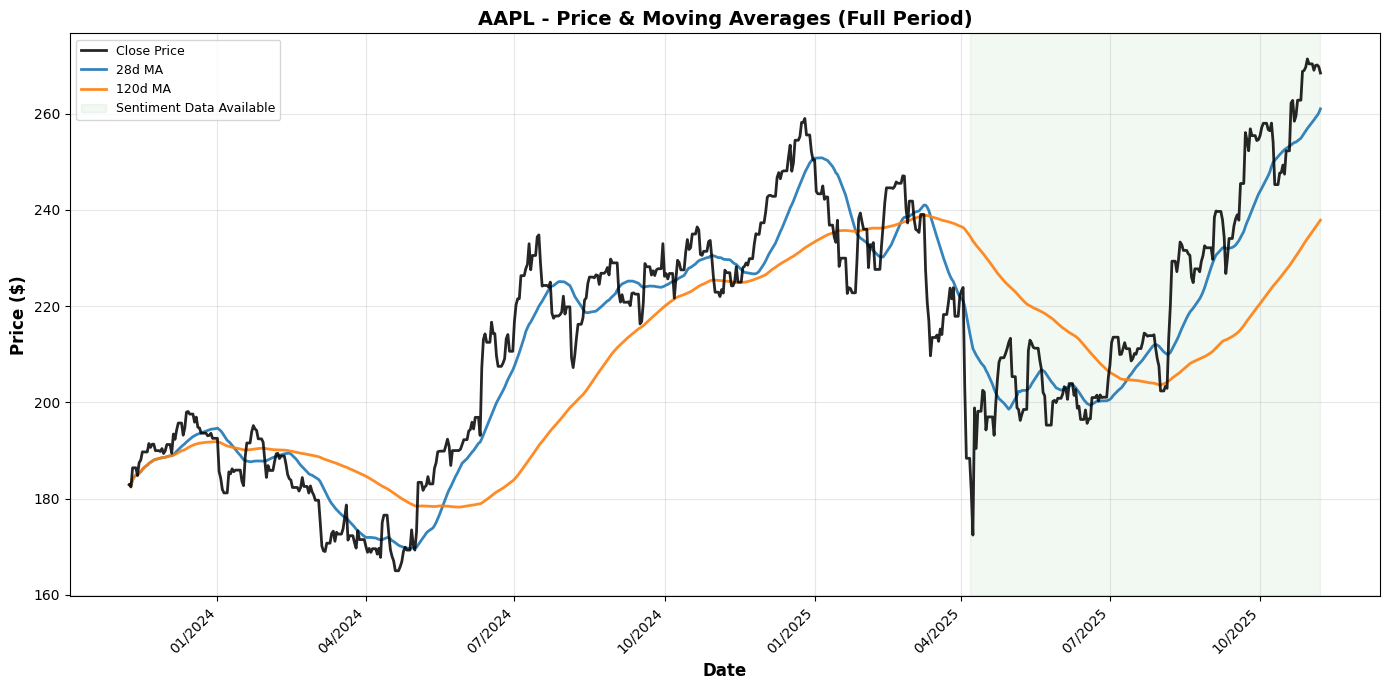

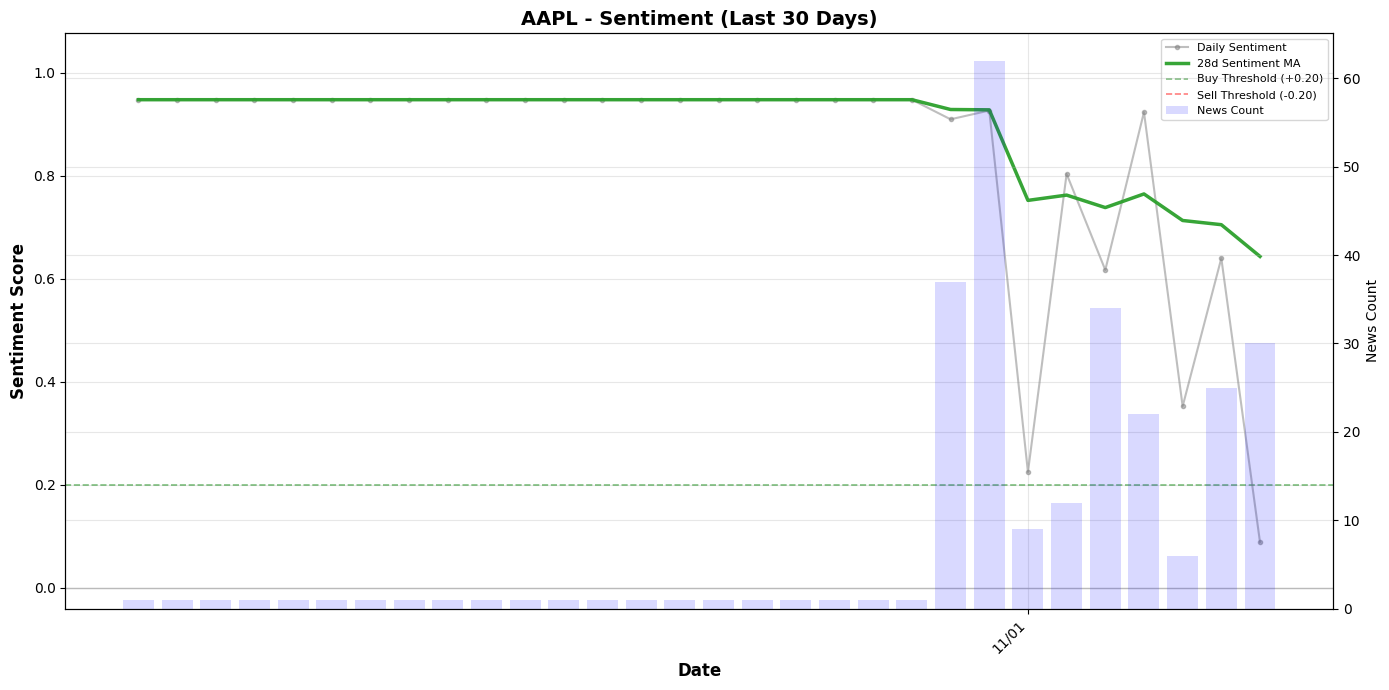

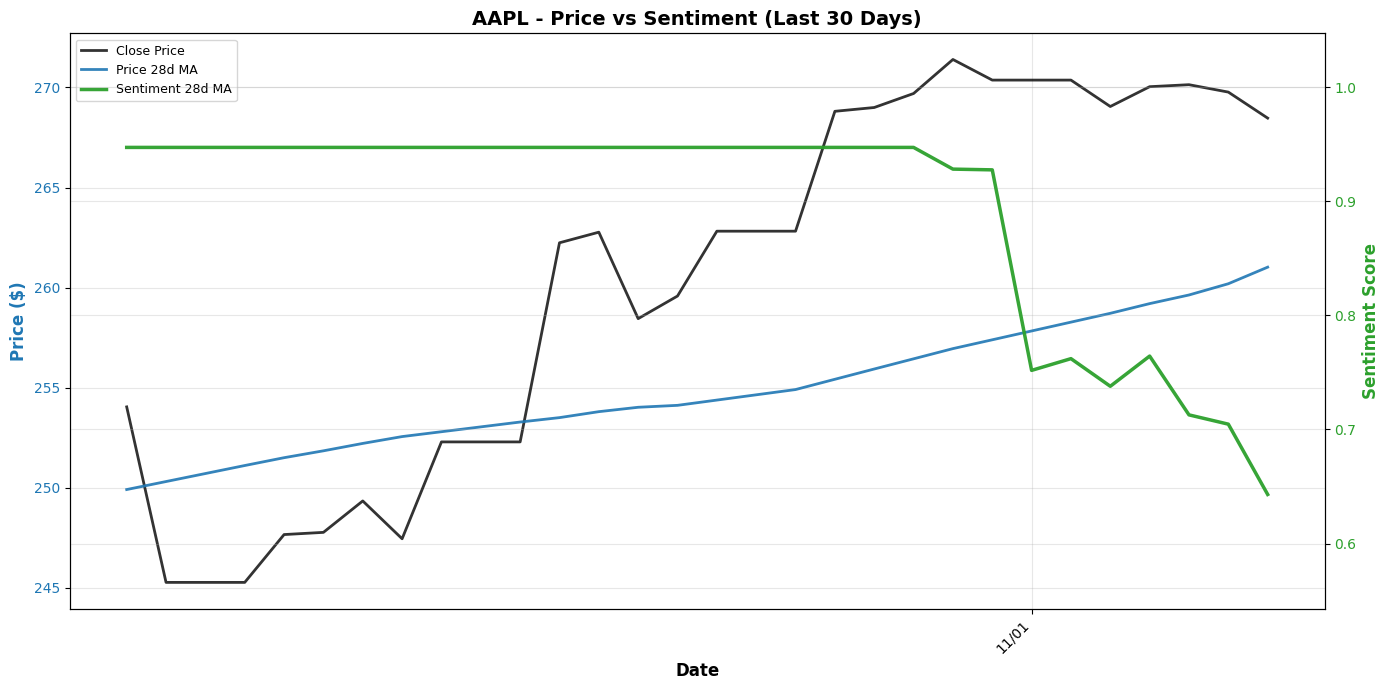


📊 Plotting MSFT...
   MSFT: Price window = 2023-11-08 → 2025-11-07 | Sentiment window = 2025-10-09 → 2025-11-07 (30 days)


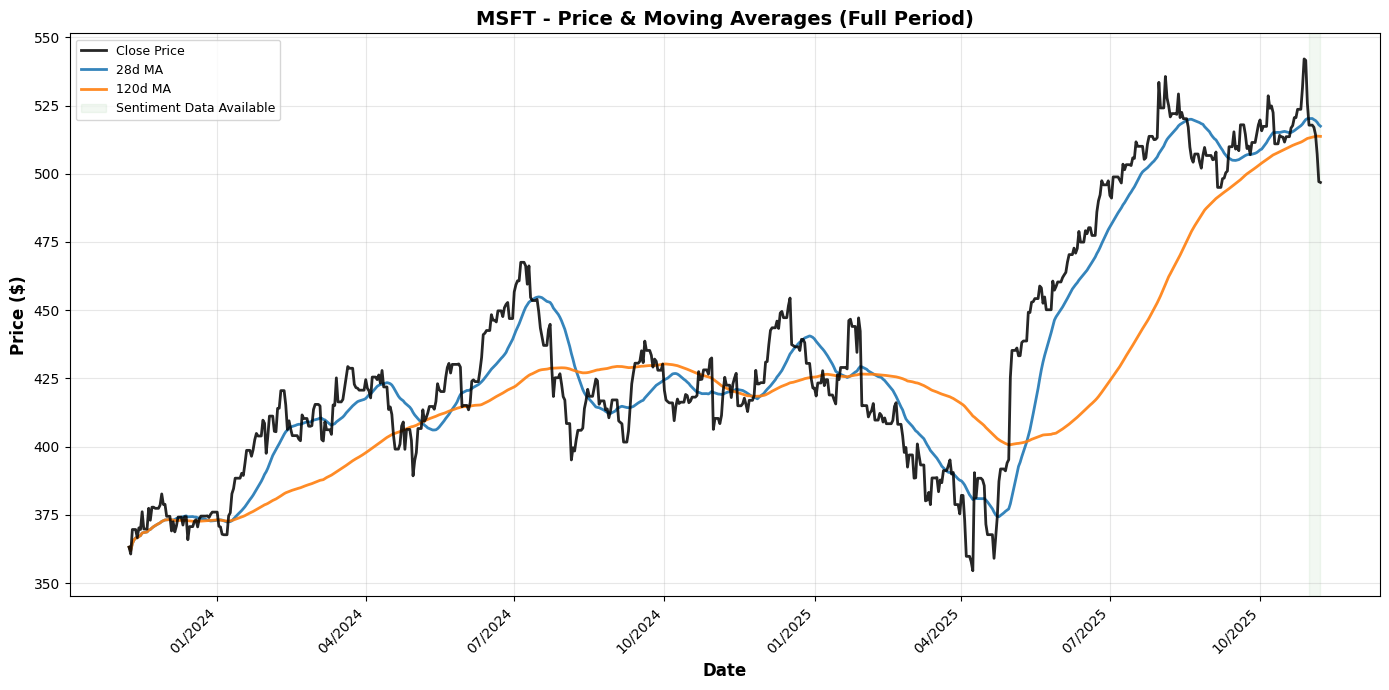

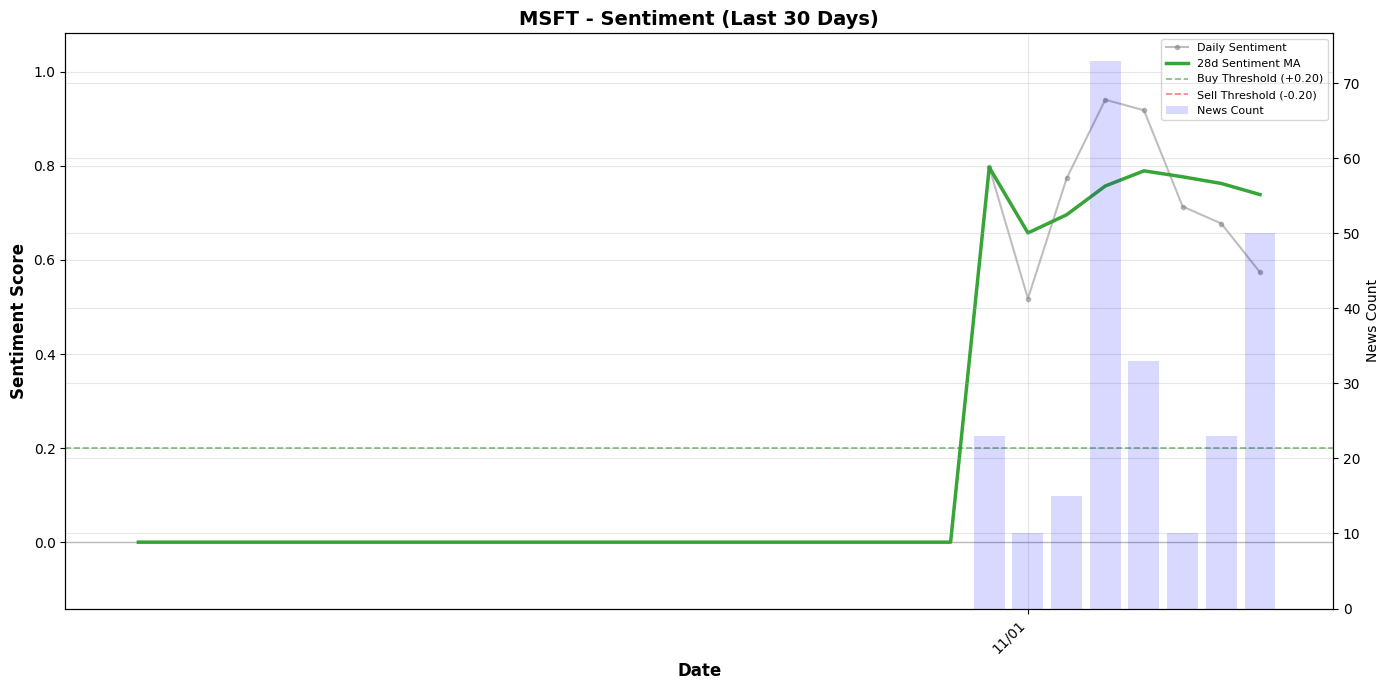

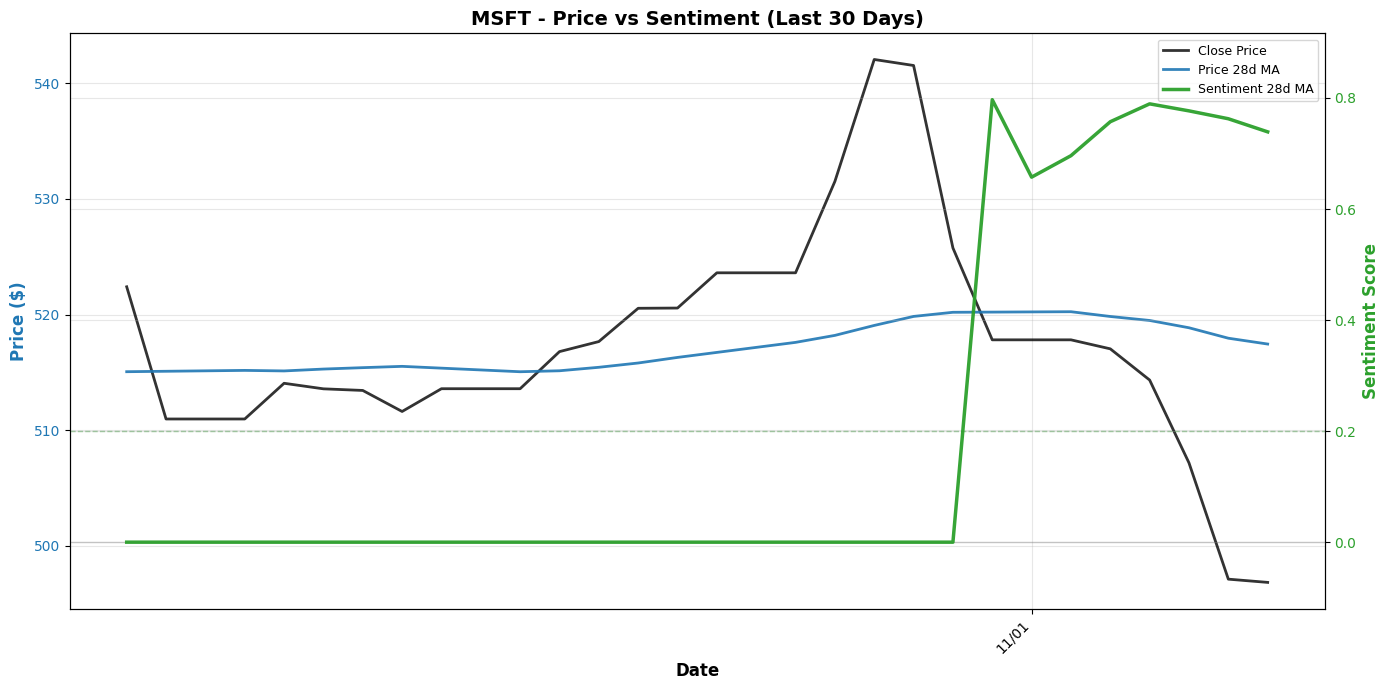


📊 Plotting GOOGL...
   GOOGL: Price window = 2023-11-08 → 2025-11-07 | Sentiment window = 2025-10-09 → 2025-11-07 (30 days)


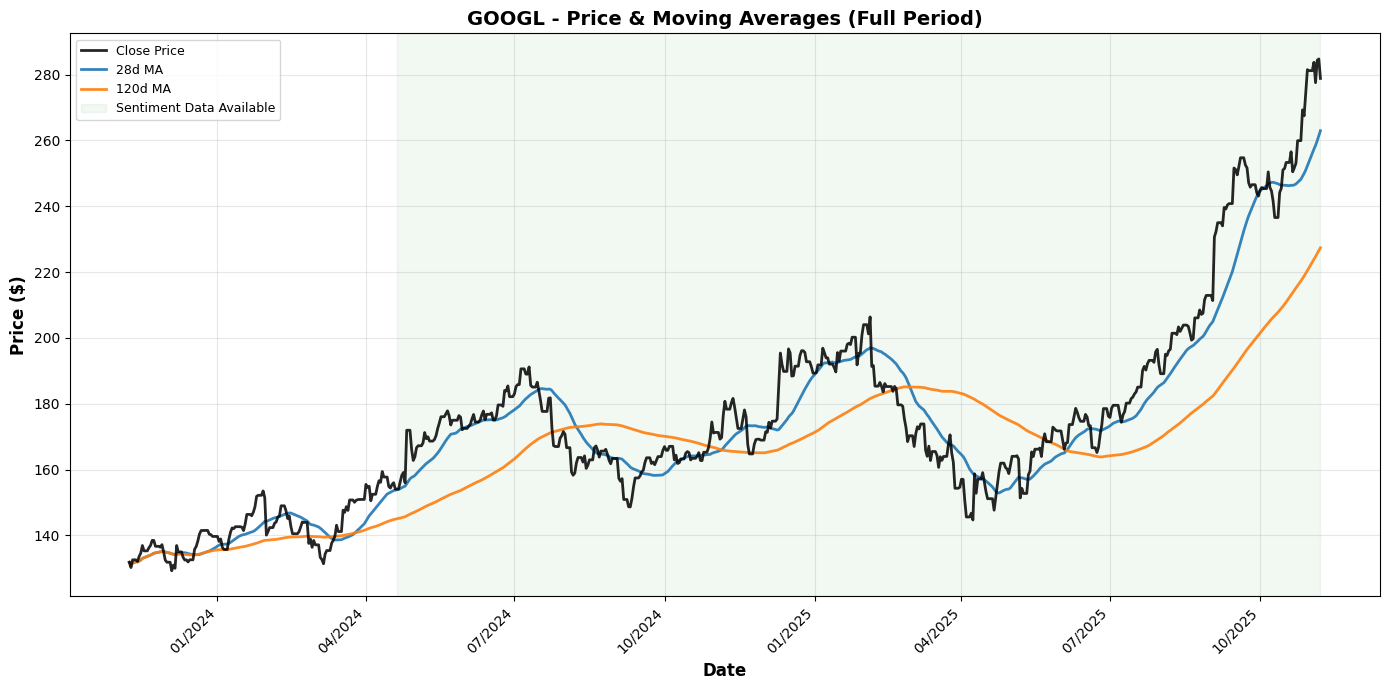

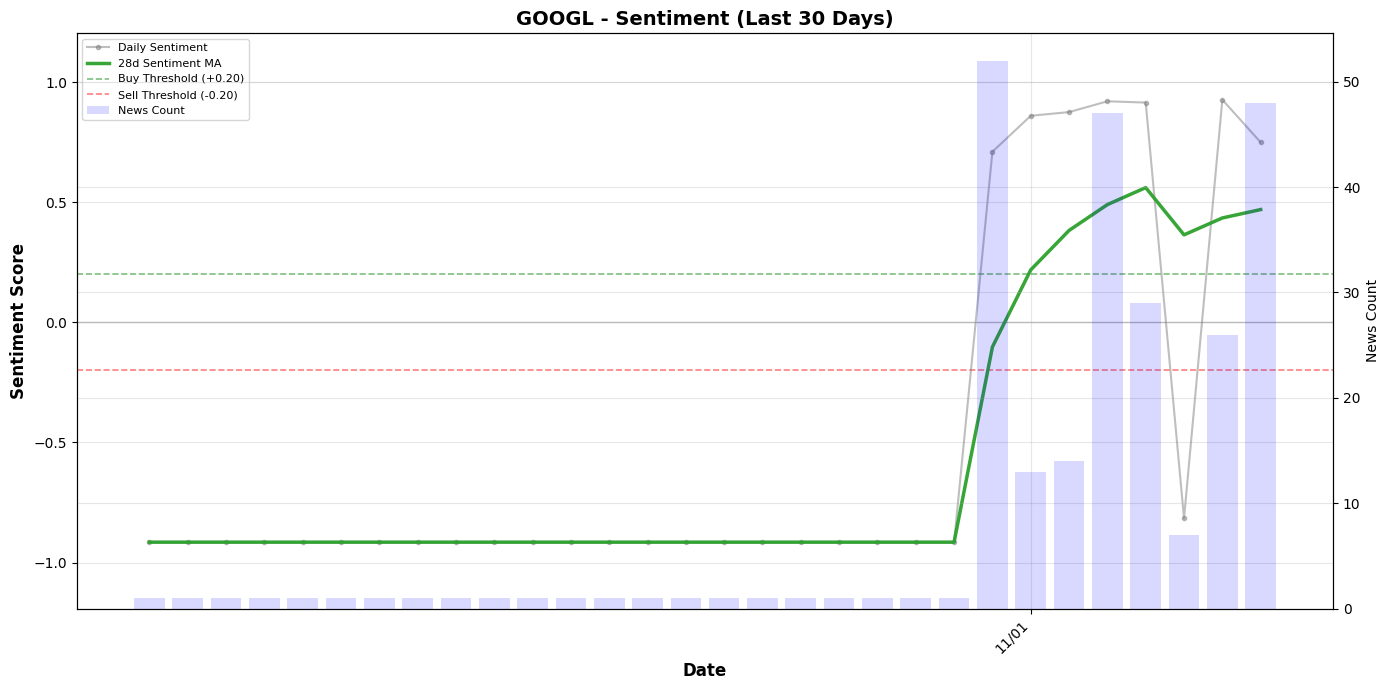

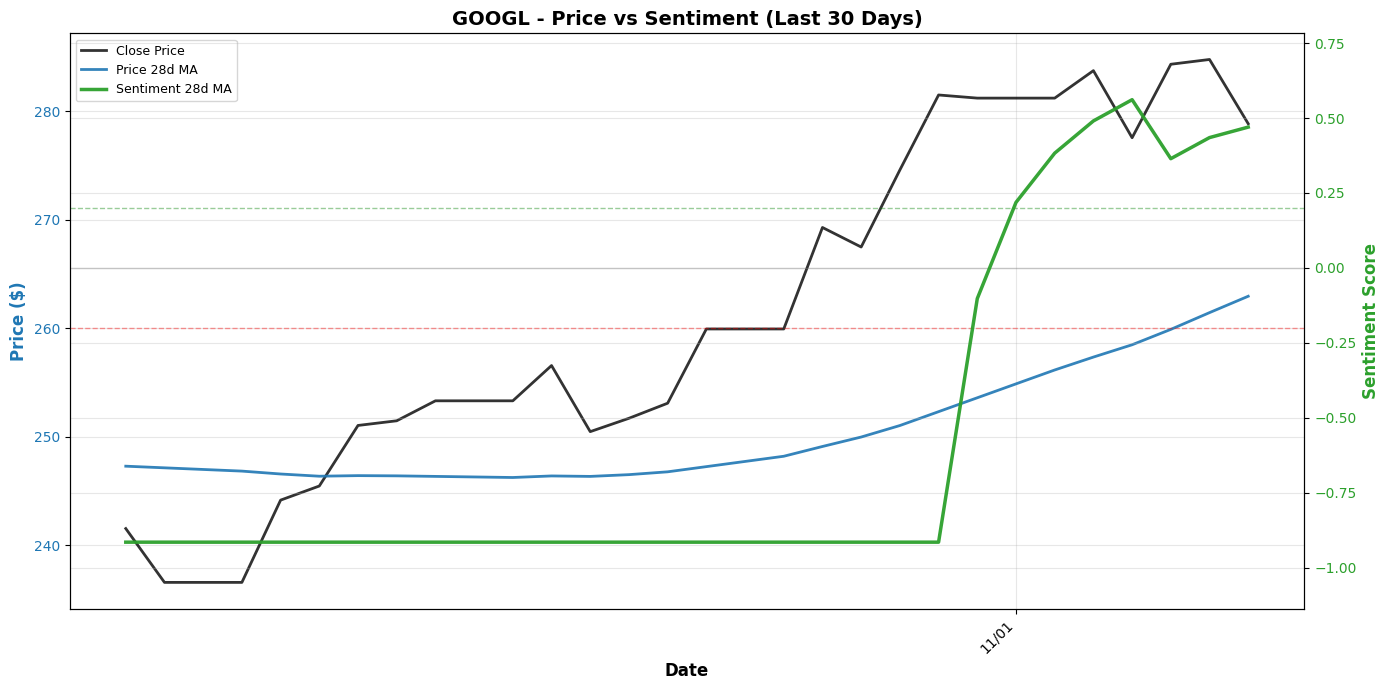


📊 Generating correlation heatmap (full data)...

📊 Generating correlation heatmap...


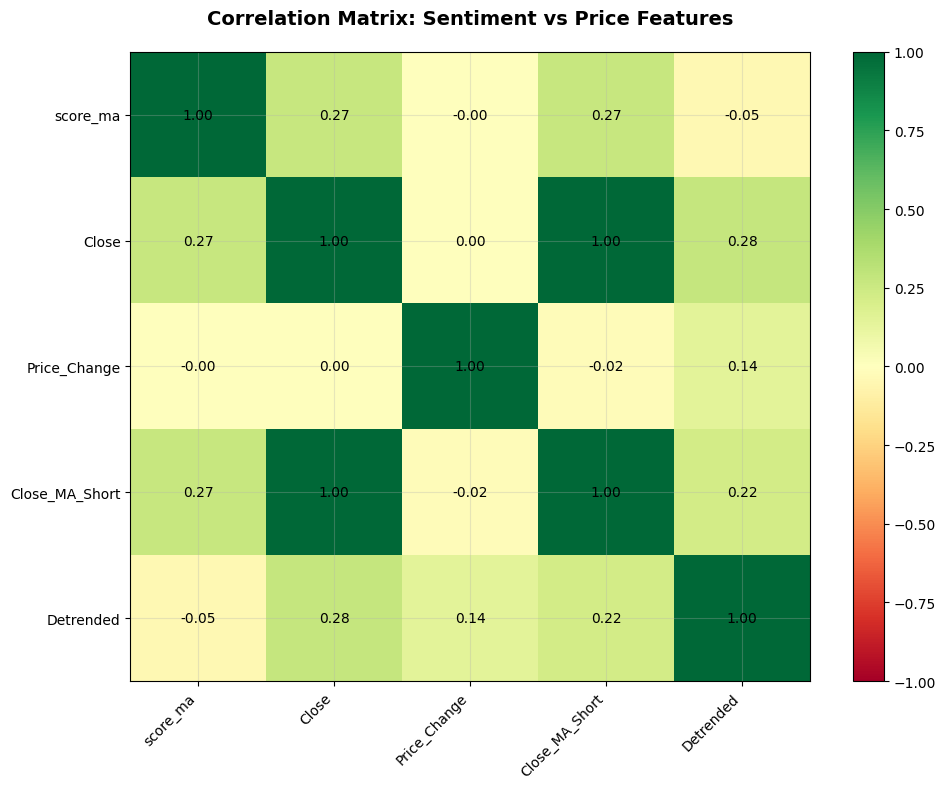


✅ All visualizations complete


In [151]:
# # Cell 12: Generate Visualizations

# %%
if df_combo is not None:
    print("\n" + "=" * 70)
    print(" " * 20 + "GENERATING VISUALIZATIONS")
    print("=" * 70)
    
    for ticker in Config.TICKERS:
        print(f"\n📊 Plotting {ticker}...")
        plot_ticker_analysis(
            ticker,
            df_combo,
            sentiment_lookback_days=Config.MIN_SENTIMENT_DAYS  # 30 days
        )
    
    print("\n📊 Generating correlation heatmap (full data)...")
    plot_correlation_heatmap(df_combo)
    
    print("\n✅ All visualizations complete")
else:
    print("⚠️  No data to visualize")


In [152]:
# # Cell 13: Correlation Analysis

# %%
if df_combo is not None:
    df_correlations = analyze_correlations(df_combo)
    if not df_correlations.empty:
        print("\n📋 Correlation Summary:")
        print(df_correlations.to_string(index=False))
else:
    print("⚠️  No data for correlation analysis")



📊 CORRELATION ANALYSIS

AAPL:
  Data points: 730
  Sentiment ↔ Price: +0.209
  Sentiment ↔ Price Change: +0.053
  Lagged correlations:
    lag_1d: +0.052
    lag_3d: +0.072
    lag_5d: +0.049
    lag_7d: +0.041
    lag_14d: +0.044

GOOGL:
  Data points: 730
  Sentiment ↔ Price: -0.421
  Sentiment ↔ Price Change: -0.009
  Lagged correlations:
    lag_1d: -0.006
    lag_3d: -0.006
    lag_5d: +0.001
    lag_7d: +0.013
    lag_14d: +0.006

MSFT:
  Data points: 730
  Sentiment ↔ Price: +0.181
  Sentiment ↔ Price Change: -0.071
  Lagged correlations:
    lag_1d: -0.056
    lag_3d: -0.062
    lag_5d: -0.067
    lag_7d: -0.003
    lag_14d: +nan


📋 Correlation Summary:
ticker  data_points  sentiment_price_corr  sentiment_change_corr   lag_1d    lag_3d    lag_5d    lag_7d  lag_14d
  AAPL          730              0.209143               0.052545  0.05238  0.071701  0.048503  0.041115 0.044296
 GOOGL          730             -0.421061              -0.009401 -0.00573 -0.006322  0.000704  0.01299

C:\Users\Samuel\AppData\Local\Temp\ipykernel_4636\2275191956.py:33: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  lagged_corrs[f'lag_{lag}d'] = stats.pearsonr(



🔧 Building prediction features (horizon: 3 days)...
✅ Features built: 2151 samples, 11 features

🤖 PREDICTIVE MODELING

Train: 1720 samples
Test:  431 samples

🎯 Training Random Forest...

📈 Results:
  Train Accuracy: 79.24%
  Test Accuracy:  49.65%

📊 Classification Report:
              precision    recall  f1-score   support

        Down       0.44      0.32      0.37       200
          Up       0.52      0.65      0.58       231

    accuracy                           0.50       431
   macro avg       0.48      0.48      0.48       431
weighted avg       0.49      0.50      0.48       431


🔝 Top 5 Features:
  rsi: 0.1775
  detrended: 0.1656
  ma_crossover: 0.1608
  price_volatility: 0.1435
  price_change_5d: 0.1227


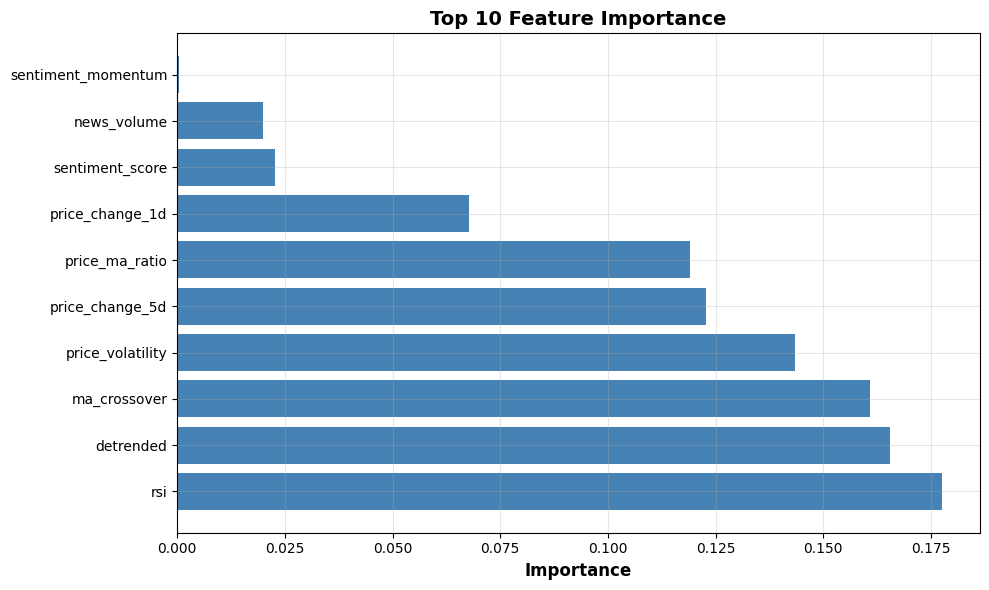


📊 Visualizing prediction results...
⚠️  No test data for AAPL


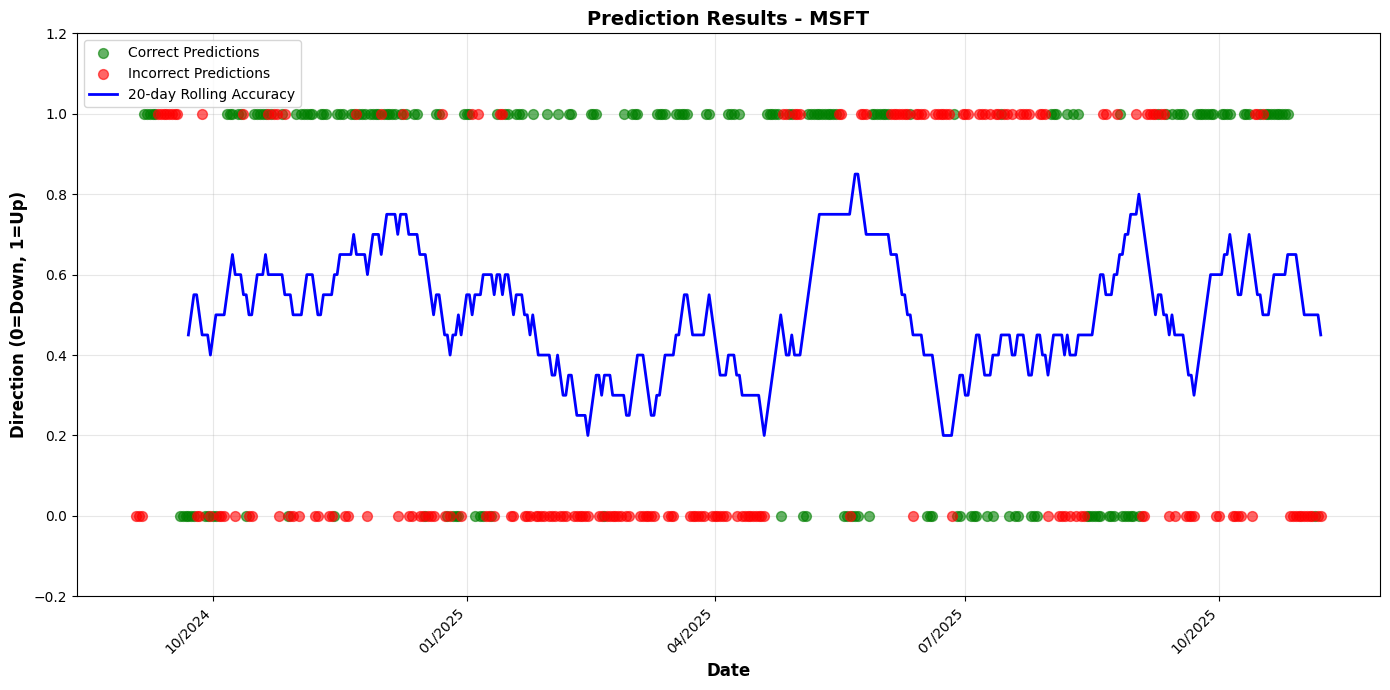

⚠️  No test data for GOOGL


In [153]:
# # Cell 14: Build Predictive Model

# %%
if df_combo is not None:
    X, y, feature_names, metadata = build_prediction_features(df_combo, Config.PREDICTION_HORIZON)
    
    if X is not None and len(X) > 100:
        model, scaler, feature_importance, test_data = train_prediction_model(X, y, metadata)
        
        # Visualize feature importance
        fig, ax = plt.subplots(figsize=(10, 6))
        top_features = feature_importance.head(10)
        ax.barh(range(len(top_features)), top_features['importance'], color='steelblue')
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'])
        ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
        ax.set_title('Top 10 Feature Importance', fontsize=14, fontweight='bold')
        ax.grid(True, alpha=Config.GRID_ALPHA, axis='x')
        plt.tight_layout()
        plt.show()
        
        print("\n📊 Visualizing prediction results...")
        for ticker in Config.TICKERS:
            plot_prediction_results(test_data, ticker_to_plot=ticker)
        
    else:
        print("⚠️  Insufficient data for predictive modeling")
else:
    print("⚠️  No data for predictive modeling")


📈 BACKTESTING SENTIMENT TRADING STRATEGY
Rules:
  • BUY:  Sentiment MA > +0.20
  • SELL: Sentiment MA < -0.20
  • HOLD: Otherwise

AAPL:
  Period: 216 days
  Total Trades: 216 (Win Rate: 38.4%)
  Buy-and-Hold Return: +42.52%
  Strategy Return: +42.52%
  Excess Return: +0.00%


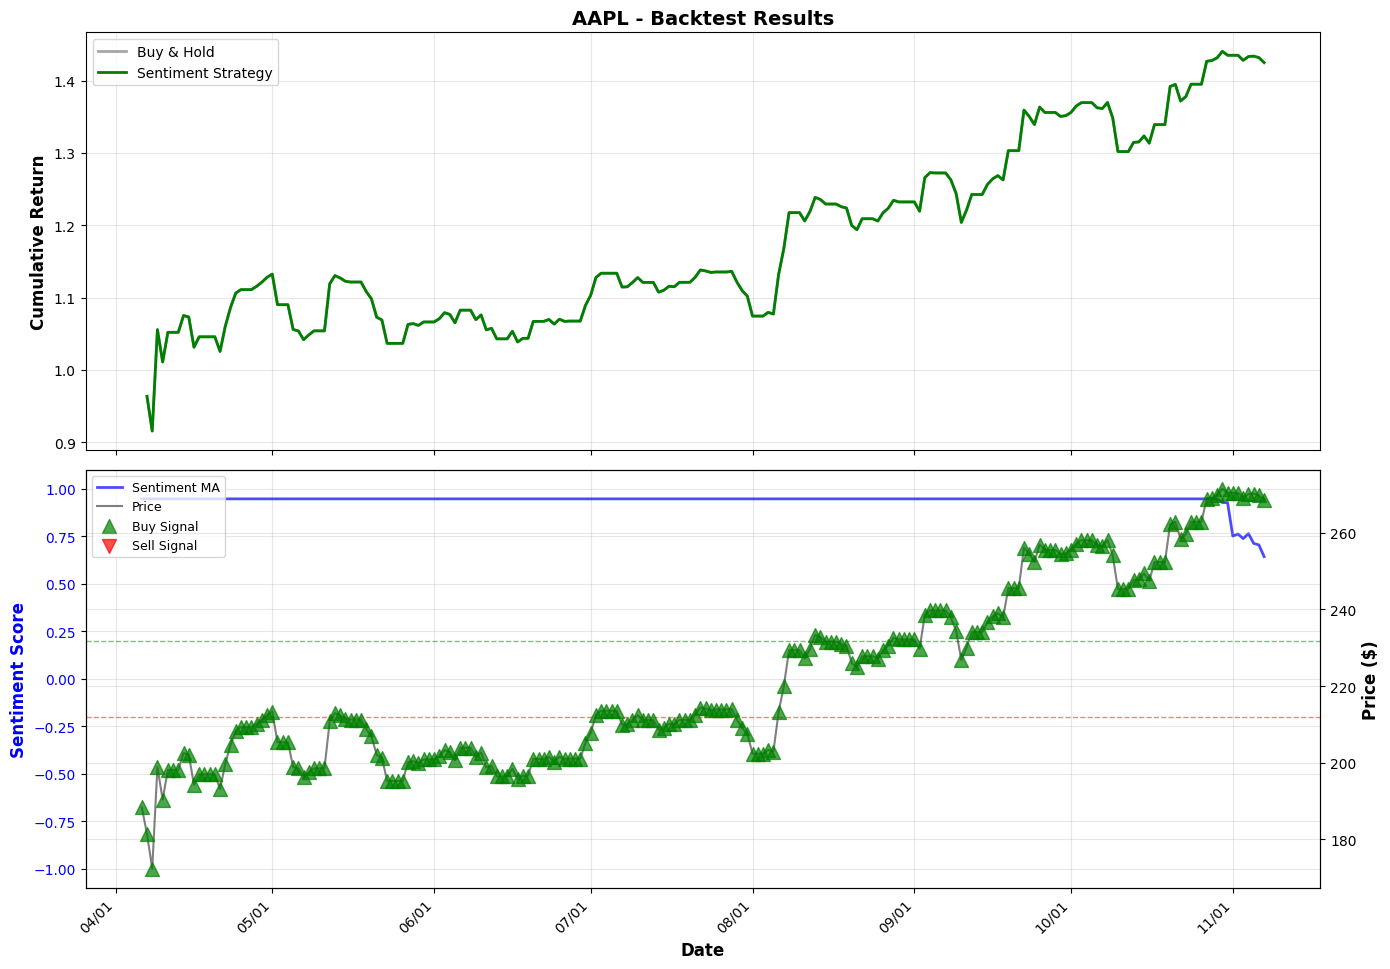


GOOGL:
  Period: 567 days
  Total Trades: 566 (Win Rate: 30.0%)
  Buy-and-Hold Return: +80.95%
  Strategy Return: -53.02%
  Excess Return: -133.98%


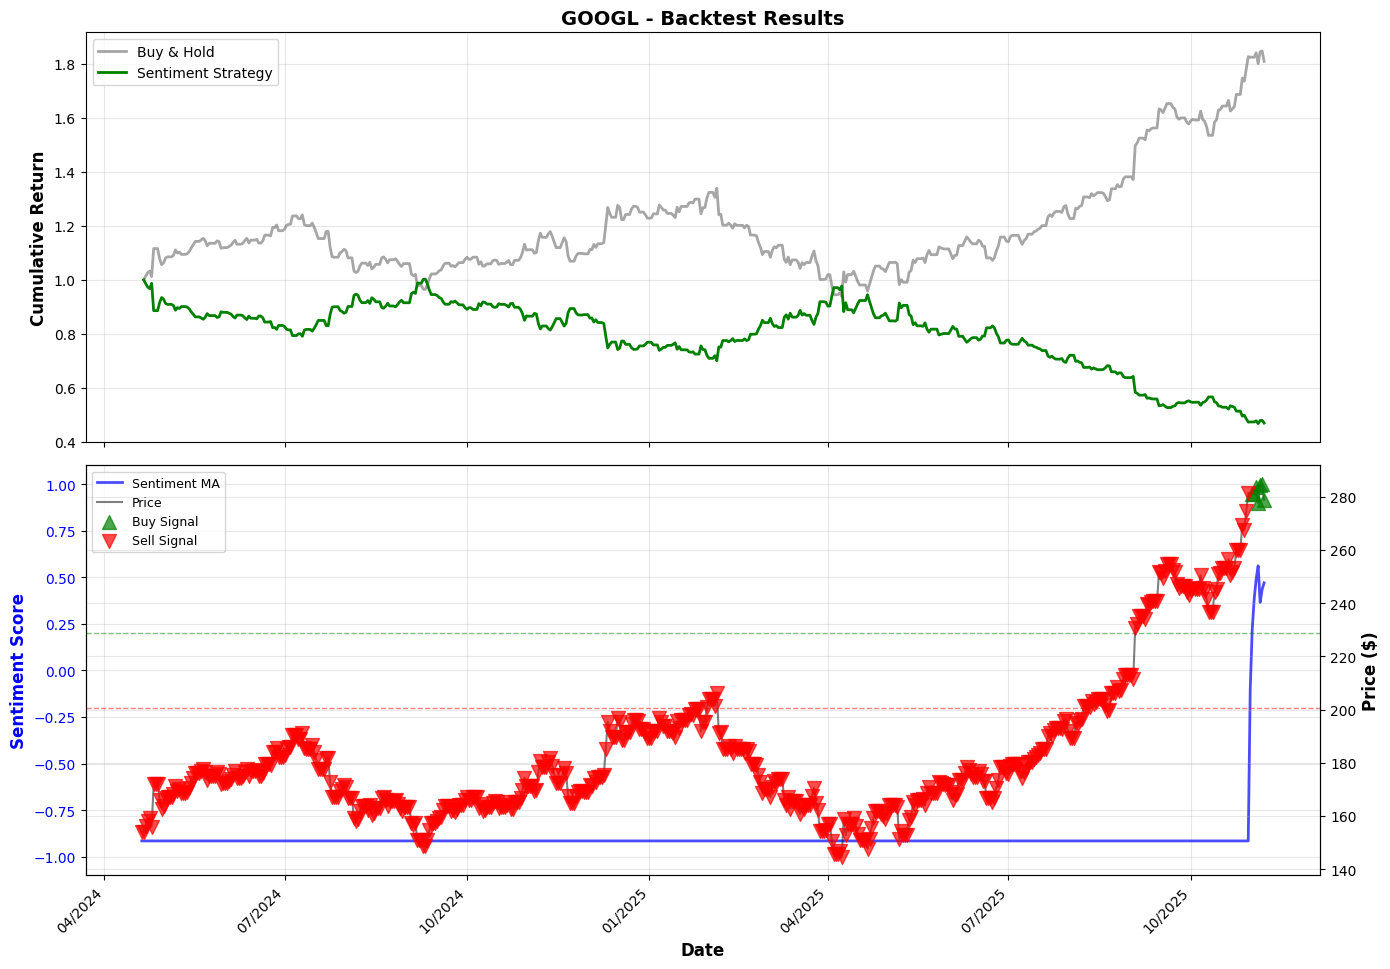


⚠️  MSFT: Insufficient sentiment data


📋 Backtest Summary:
ticker  period_days  total_trades  win_rate  market_return  strategy_return  excess_return  strategy_sharpe  market_sharpe
  AAPL          216           216 38.425926      42.515126        42.515126       0.000000         1.613367       1.613367
 GOOGL          567           566 30.035336      80.952686       -53.023371    -133.976056        -1.188017       1.161246


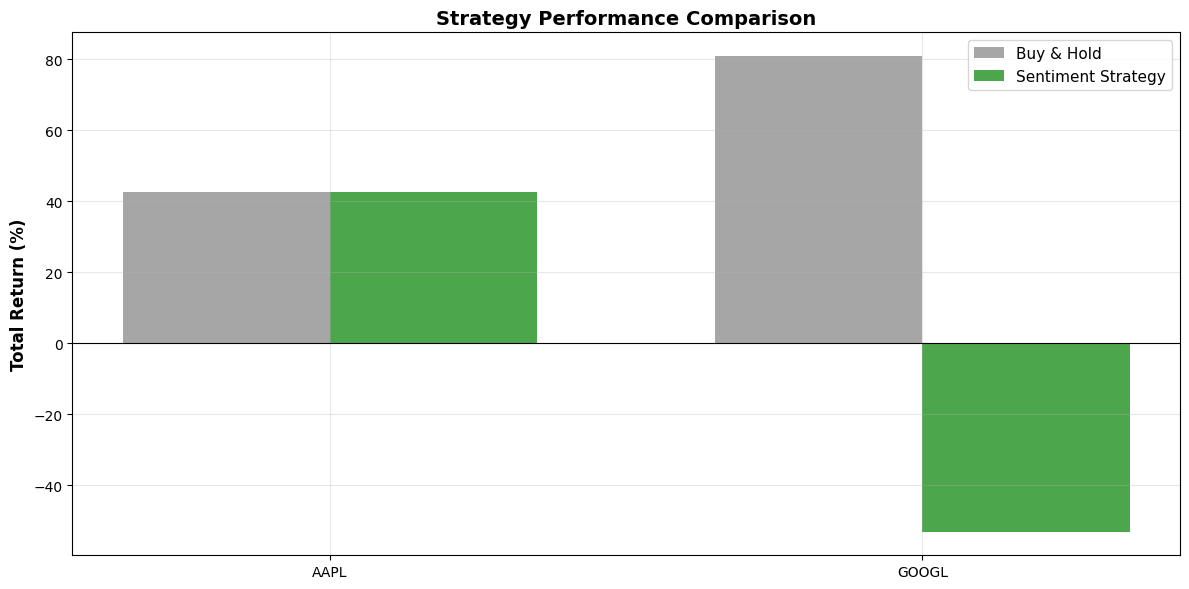

In [154]:
# # Cell 15: Backtest Trading Strategy

# %%
if df_combo is not None:
    backtest_results = backtest_sentiment_strategy(df_combo)
    
    if not backtest_results.empty:
        print("\n📋 Backtest Summary:")
        print(backtest_results.to_string(index=False))
        
        fig, ax = plt.subplots(figsize=(12, 6))
        x = range(len(backtest_results))
        width = 0.35
        
        ax.bar([i - width/2 for i in x], backtest_results['market_return'], 
               width, label='Buy & Hold', color='gray', alpha=0.7)
        ax.bar([i + width/2 for i in x], backtest_results['strategy_return'], 
               width, label='Sentiment Strategy', color='green', alpha=0.7)
        
        ax.set_ylabel('Total Return (%)', fontsize=12, fontweight='bold')
        ax.set_title('Strategy Performance Comparison', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(backtest_results['ticker'])
        ax.legend(fontsize=11)
        ax.grid(True, alpha=Config.GRID_ALPHA, axis='y')
        ax.axhline(0, color='black', linewidth=0.8)
        
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️  No backtest results available")
else:
    print("⚠️  No data for backtesting")


In [155]:
# # Cell 16: Summary & Key Insights

# %%
if df_combo is not None:
    print("\n" + "=" * 70)
    print(" " * 25 + "ANALYSIS SUMMARY")
    print("=" * 70)
    
    for ticker in Config.TICKERS:
        if ticker in df_combo.index.get_level_values('ticker'):
            tdf = df_combo.xs(ticker, level='ticker')
            has_sentiment = tdf['entry_count'] > 0
            
            print(f"\n{ticker}:")
            print(f"  • Total data points: {len(tdf)}")
            print(f"  • Days with sentiment: {has_sentiment.sum()}")
            print(f"  • Avg sentiment score: {tdf['score_ma'].mean():+.3f}")
            print(f"  • Price range: ${tdf['Close'].min():.2f} - ${tdf['Close'].max():.2f}")
            print(f"  • Total return: {((tdf['Close'].iloc[-1] / tdf['Close'].iloc[0]) - 1) * 100:+.2f}%")
    
    print("\n" + "=" * 70)
    print("✅ COMPLETE ANALYSIS FINISHED")
    print("=" * 70)
    print("\n📊 Generated outputs:")
    print("  • Price & sentiment visualizations (using config parameters)")
    print("  • Correlation analysis")
    print("  • Predictive model (if sufficient data)")
    print("  • Backtested trading strategy")
    print("\n💡 Configuration used:")
    print(f"  • Rolling window: {Config.ROLLING_WINDOW_DAYS} days")
    print(f"  • Long MA: {Config.LONG_MA_DAYS} days")
    print(f"  • Buy threshold: {Config.SENTIMENT_BUY_THRESHOLD}")
    print(f"  • Sell threshold: {Config.SENTIMENT_SELL_THRESHOLD}")
    print(f"  • Prediction horizon: {Config.PREDICTION_HORIZON} days")
    print("\n🔧 To modify analysis, edit values in Cell 2 (Config class)")
    print("=" * 70)
else:
    print("⚠️  Analysis incomplete - no data available")



                         ANALYSIS SUMMARY

AAPL:
  • Total data points: 731
  • Days with sentiment: 216
  • Avg sentiment score: +0.278
  • Price range: $165.00 - $271.40
  • Total return: +46.79%

MSFT:
  • Total data points: 731
  • Days with sentiment: 8
  • Avg sentiment score: +0.008
  • Price range: $354.56 - $542.07
  • Total return: +36.79%

GOOGL:
  • Total data points: 731
  • Days with sentiment: 567
  • Avg sentiment score: -0.696
  • Price range: $129.27 - $284.75
  • Total return: +111.49%

✅ COMPLETE ANALYSIS FINISHED

📊 Generated outputs:
  • Price & sentiment visualizations (using config parameters)
  • Correlation analysis
  • Predictive model (if sufficient data)
  • Backtested trading strategy

💡 Configuration used:
  • Rolling window: 28 days
  • Long MA: 120 days
  • Buy threshold: 0.2
  • Sell threshold: -0.2
  • Prediction horizon: 3 days

🔧 To modify analysis, edit values in Cell 2 (Config class)


In [156]:
print(df_combo.tail())

                        Close     score  entry_count  score_ma  \
ticker date                                                      
MSFT   2025-11-03  517.030029  0.940696         73.0  0.757236   
       2025-11-04  514.330017  0.918247         33.0  0.789438   
       2025-11-05  507.160004  0.713597         10.0  0.776798   
       2025-11-06  497.100006  0.677452         23.0  0.762606   
       2025-11-07  496.820007  0.573723         50.0  0.738995   

                   entry_count_ma  Close_MA_Short  Close_MA_Long  Detrended  \
ticker date                                                                   
MSFT   2025-11-03       30.250000      519.830354     513.563998   3.466031   
       2025-11-04       30.800000      519.485712     513.702415   0.627602   
       2025-11-05       27.333333      518.853928     513.790248  -6.630245   
       2025-11-06       26.714286      517.950356     513.736832 -16.636826   
       2025-11-07       29.625000      517.445356     513.69799